# Diabetes Prediction with the PIMA Indian Diabetes Dataset #
#### *This project explores the mathematical foundations of neural networks, focusing on understanding how mathematics can uncover complex relationships within diverse datasets*

In [12]:
import torch
import numpy as np
import pandas as pd
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

In [107]:
# Load the dataset
df = pd.read_csv('diabetes.csv')

The dataset for this project is sourced from the PIMA Indians Diabetes Dataset, sourced from https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database

In [29]:
# Observe the dataset for the data columns and any missing data values
display(df.head())
display(df.isna().sum())

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

Noting the data columns, there are 8 columns containing data relevant to the patient, and one column (Outcome) relating to the diabetes status of the patient. From the dataset, an outcome of 1 indicates that the patient has diabetes, and an outcome of 0 indicates that the patient does not have diabetes.

In [34]:
# Preprocess the dataset

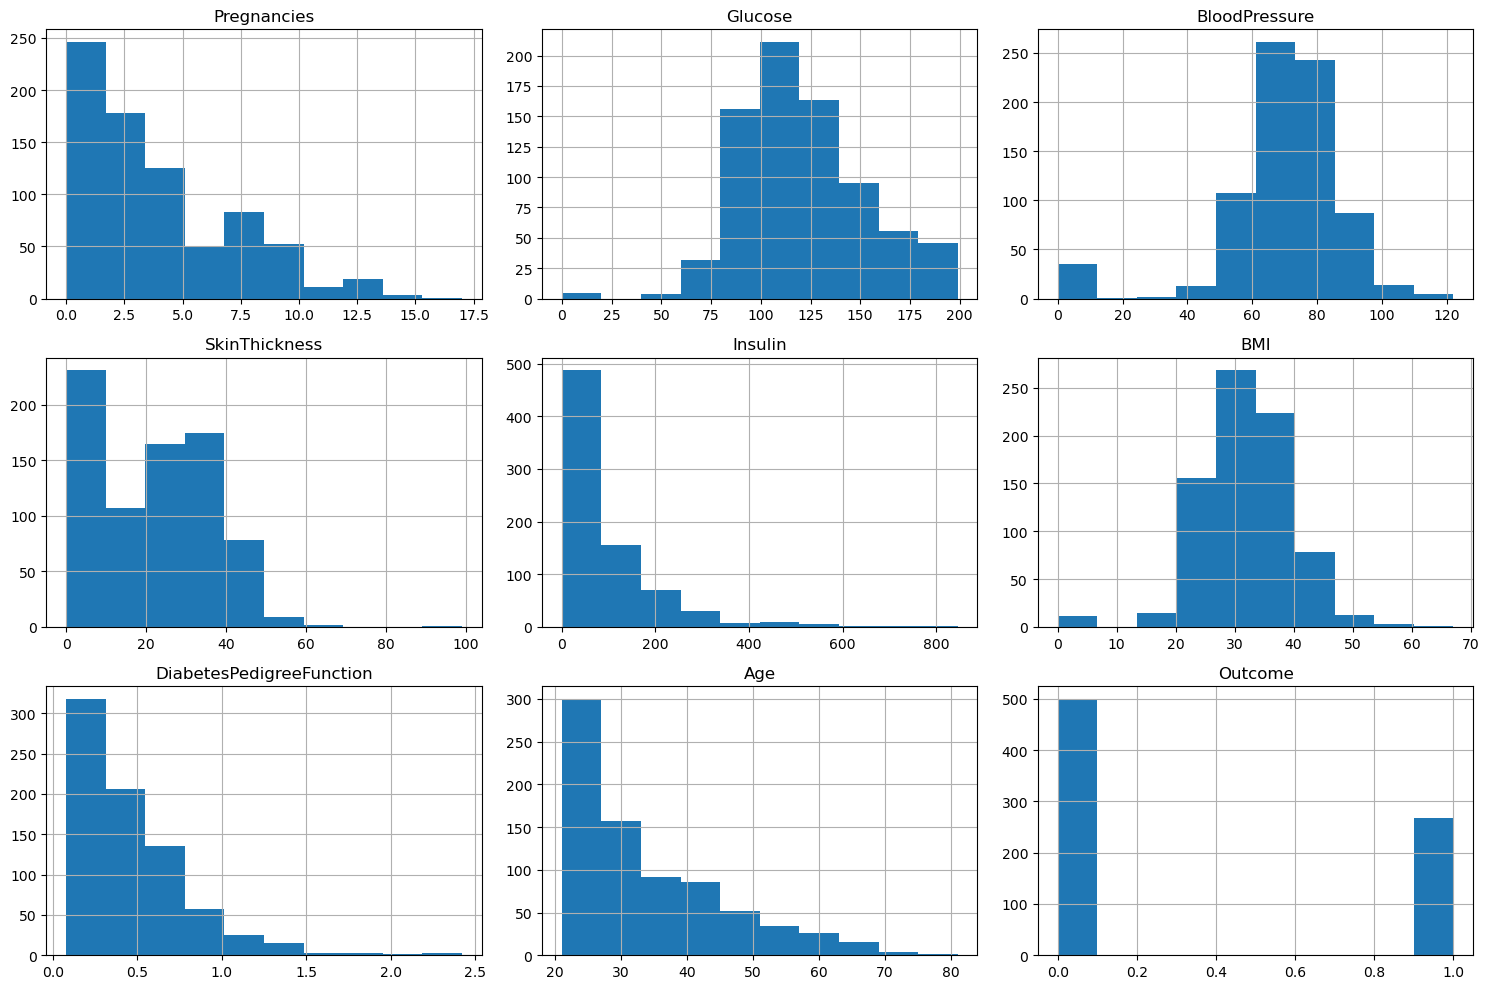

In [46]:
import matplotlib.pyplot as plt

# Determine the number of rows and columns for the grid
n_cols = 3
n_rows = int(np.ceil(len(df.columns) / n_cols))

# Create the subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))

# Plot each column in the grid
for i, col in enumerate(df.columns):
    ax = axes[i // n_cols, i % n_cols]
    df[col].hist(ax=ax)
    ax.set_title(col)

# Hide any unused subplots
for j in range(i + 1, n_rows * n_cols):
    fig.delaxes(axes[j // n_cols, j % n_cols])

plt.tight_layout()
plt.show()


The histogram of each column of data indicates that some of the data columsn are long-tail skewed. It is wise to address these issues as machine learning models trained on skewed data can lead to a variety of problems affecting the accuracy of the model such as:
1. Overfitting to Majority Classes: Models may perform well on majority classes but poorly on minority classes because they receive more training examples.
2. Skewed Predictions: The model might become biased towards the majority class, leading to skewed predictions and poor performance on minority classes.
3. Sparse Data: There may not be enough examples of minority classes for the model to learn meaningful patterns.

While we are able to visually observe the skewed distribution of data, we can mathematically determine the skewedness using the Pareto index.

In [51]:
for col in df.columns:
    sorted_col = df[col].sort_values(ascending=False)
    cumulative_sum = sorted_col.cumsum()
    total_sum = sorted_col.sum()
    pareto_index = cumulative_sum.searchsorted(0.8 * total_sum) / len(sorted_col)
    print(f"{col}: Pareto index = {pareto_index}")

Pregnancies: Pareto index = 0.4388020833333333
Glucose: Pareto index = 0.71875
BloodPressure: Pareto index = 0.7122395833333334
SkinThickness: Pareto index = 0.47265625
Insulin: Pareto index = 0.2877604166666667
BMI: Pareto index = 0.72265625
DiabetesPedigreeFunction: Pareto index = 0.5677083333333334
Age: Pareto index = 0.703125
Outcome: Pareto index = 0.2786458333333333


The lower the Pareto index of a data column is, the more long-tail skewed the data is. Using the Pareto index, it is noted that the Insulin category is the most heavily skewed with a Pareto index of 0.29. To address this issue, we can take the log of the entire column to distribute the data normally. In addition, to read more about the Pareto index, https://en.wikipedia.org/wiki/Pareto_principle

<Axes: >

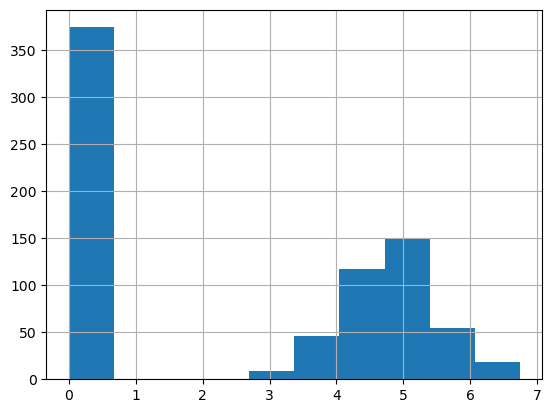

In [109]:
df['logInsulin'] = np.log(df['Insulin'] + 1)
df.drop('Insulin', axis=1, inplace=True)
df['logInsulin'].hist()

The data for this column now appears to be more normally distributed, allowing for a potential improvement in the models accuracy

In [111]:
# Observe the variability of the data among different columns
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,BMI,DiabetesPedigreeFunction,Age,Outcome,logInsulin
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,31.992578,0.471876,33.240885,0.348958,2.471968
std,3.369578,31.972618,19.355807,15.952218,7.884160,0.331329,11.760232,0.476951,2.460253
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,27.300000,0.243750,24.000000,0.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,32.000000,0.372500,29.000000,0.000000,3.448852
75%,6.000000,140.250000,80.000000,32.000000,36.600000,0.626250,41.000000,1.000000,4.853976
max,17.000000,199.000000,122.000000,99.000000,67.100000,2.420000,81.000000,1.000000,6.741701


Observing the mean values for each data column, is is noted that the data ranges from small to large values among the different data columns. Generally, this is not recommended for training data as this introduces the effect of scale. To avoid this, normalize the data among the independent data columns. 

In [113]:
# Standardize the dependent data columns
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df.drop('Outcome', axis=1))
df_scaled = pd.DataFrame(scaled_features, columns=df.columns.drop('Outcome'))
df_scaled['Outcome'] = df['Outcome']

In [119]:
# Convert the data to tensors
features = df_scaled.drop('Outcome', axis=1).values
labels = df_scaled['Outcome'].values
t_features = torch.tensor(features, dtype=torch.float32)
t_labels = torch.tensor(labels, dtype=torch.float32)

In order to potentially improve model performance and accuracy, it is helpful to augment the dataset by applying various transformations to the data. This process of augmentation allows for a more diverse dataset with more training samples, and allows the model to be more tolerant to slight variations in fe